# Insurance Claim Prediction

**Write the names of all group members (max. 5 members)**:
- Ramon, Kaspar
- Cyrill, Stotz

# Exercise 1 (Poisson GLM)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, model_selection, linear_model

RANDOM_STATE = 69   # for reproducibility

### Question 1.a

In [2]:
# Read csv file `freMTPL2freq.csv` (e.g. use pandas)
data_df = pd.read_csv('freMTPL2freq.csv', sep=';', decimal=',')
print("Column Names: ", data_df.columns)
print("Number of Rows: ", len(data_df))
assert len(data_df) == 678007

Column Names:  Index(['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehBrand', 'VehGas',
       'Density', 'Region', 'Exposure', 'ClaimNb'],
      dtype='object')
Number of Rows:  678007


In [3]:
# Pre-process features

def preprocess_features(df):
    """Feature Engineering"""
    df_processed = df.copy()
    
    df_processed['VehPower'] = np.log(df_processed['VehPower'])
    df_processed['DrivAge'] = np.log(df_processed['DrivAge'])
    df_processed['BonusMalus'] = np.log(df_processed['BonusMalus'])
    df_processed['Density'] = np.log(df_processed['Density'])
    
    # Convert VehAge to categorical
    def categorize_veh_age(age):
        if age < 6:
            return '0-6'
        elif age < 13:
            return '6-13'
        else:
            return '13+'
        
    df_processed['VehAge'] = df_processed['VehAge'].apply(categorize_veh_age)

    return df_processed

# Calculate claim frequency, i.e., the target variable y
data_df['ClaimFreq'] = data_df['ClaimNb'] / data_df['Exposure']

# Preprocess features
data_processed_df = preprocess_features(data_df)

### Question 1.b

In [4]:
# Print some statistics about the data
print(f"Average Claim Frequency: {data_df['ClaimFreq'].mean()}")
print(f"Standard deviation of Claim Frequency: {data_df['ClaimFreq'].std()}")
print(f"Number of Claims: {data_df['ClaimNb'].sum()}")
number_of_policies_without_claims = len(data_df[data_df['ClaimNb'] == 0])
num_of_policies_without_claims_rel = 100*number_of_policies_without_claims / len(data_df)
print(f"Number of Policies without Claims: {number_of_policies_without_claims} ({num_of_policies_without_claims_rel:.2f}%)")
print(f"Number of NaNs: {data_processed_df.isna().sum().sum()}")

Average Claim Frequency: 0.11790710080746372
Standard deviation of Claim Frequency: 2.0028805595870742
Number of Claims: 26383
Number of Policies without Claims: 653069 (96.32%)
Number of NaNs: 0


**COMMENT:** We can see that most policy holders have no claims at all (i.e., $96.32\%$ of the policy holders have zero claims). So when we would model the problem as binary classification, we would have a very imbalanced dataset. Therefore, Poisson regression is a not a bad choice here. \
If we look at the average and the std we see that they are not equal, this indicates that Poisson regression may have some trouble to fit a good model (overdispersion). Since the Exercise hinted to us to work with the linear_model.PoissonRegressor from sklearn we go with this model. \
Furthermore, we don't have any NaNs in the dataset, so we don't have to deal with missing values – nice.

In [5]:
# Train-test split
X = data_processed_df.drop(['Exposure', 'ClaimNb', 'ClaimFreq'], axis=1)
y = data_df['ClaimFreq']
exposure = data_df['Exposure']

X_train, X_test, y_train, y_test, exposure_train, exposure_test = model_selection.train_test_split(
    X, y, exposure, test_size=0.1, random_state=RANDOM_STATE
)

# Separate features
categorical_features = ['VehAge', 'VehBrand', 'VehGas', 'Region']
numerical_features = ['VehPower', 'DrivAge', 'BonusMalus', 'Density']

# Scale numerical features
scaler = preprocessing.StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# One-hot encode categorical features using the training data (ensure numeric values and not booleans)
X_train = pd.get_dummies(X_train, columns=categorical_features, dtype=np.float32)
X_test = pd.get_dummies(X_test, columns=categorical_features, dtype=np.float32)

print("Features: ", X_train.columns)
print("Number of Features: ", len(X_train.columns))
assert len(X_train.columns) == len(X_test.columns)  # Ensure that the test and train set have same dimensions

Features:  Index(['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'VehAge_0-6',
       'VehAge_13+', 'VehAge_6-13', 'VehBrand_B1', 'VehBrand_B10',
       'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14',
       'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5',
       'VehBrand_B6', 'VehGas_Diesel', 'VehGas_Regular', 'Region_R11',
       'Region_R21', 'Region_R22', 'Region_R23', 'Region_R24', 'Region_R25',
       'Region_R26', 'Region_R31', 'Region_R41', 'Region_R42', 'Region_R43',
       'Region_R52', 'Region_R53', 'Region_R54', 'Region_R72', 'Region_R73',
       'Region_R74', 'Region_R82', 'Region_R83', 'Region_R91', 'Region_R93',
       'Region_R94'],
      dtype='object')
Number of Features:  42


In [6]:
# Train Poisson GLM

# NOTE: We choose alpha=0 (without regularization)
poisson_reg = linear_model.PoissonRegressor(alpha=0)
poisson_reg.fit(X_train, y_train, sample_weight=exposure_train)

y_train_pred = poisson_reg.predict(X_train)
y_test_pred = poisson_reg.predict(X_test)

In [7]:
# Print MAE, MSE and loss on train and test data sets
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_poisson_deviance

def calculate_loss(y_true, y_pred, exposure, print_results=True):
    """Calculates MAE, MSE and the exposure-weighted Poisson deviance loss."""
    # Mean Absolute Error (MAE) and Mean Squared Error (MSE)
    mae = mean_absolute_error(y_true, y_pred)
    mae_weighted = mean_absolute_error(y_true, y_pred, sample_weight=exposure)
    mse = mean_squared_error(y_true, y_pred)
    mse_weighted = mean_squared_error(y_true, y_pred, sample_weight=exposure)
    
    # Calculate Poisson deviance loss (manually, and using sklearn built-in function)
    eps = 1e-8  # Avoid log(0)
    y_true_log = np.where(y_true > 0, y_true * np.log(y_true + eps), 0)
    y_pred_log = np.where(y_pred > 0, y_true * np.log(y_pred + eps), 0)
    poisson_deviance = 2 * (y_pred - y_true - y_pred_log + y_true_log)
    exp_weighted_poisson_loss = np.sum(exposure * poisson_deviance) / np.sum(exposure) if np.sum(exposure) > 0 else 0
    
    exp_weighted_poisson_loss_sklearn = mean_poisson_deviance(y_true, y_pred, sample_weight=exposure)
    
    if print_results:
        print("---------------------------------")
        print(f"MAE: {mae:.4f}")
        print(f"MAE (Weighted): {mae_weighted:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"MSE (Weighted): {mse_weighted:.4f}")
        print(f"Exposure-Weighted Poisson Deviance Loss: {exp_weighted_poisson_loss:.4f}")
        print(f"Exposure-Weighted Poisson Deviance Loss (sklearn): {exp_weighted_poisson_loss_sklearn:.4f}")
        print("---------------------------------")
    return mae, mae_weighted, mse, mse_weighted, exp_weighted_poisson_loss


# In-sample loss
print("In-sample Loss:")
poisson_glm_res_train = calculate_loss(y_train, y_train_pred, exposure_train)

# Out-of-sample loss
print("\nOut-of-sample Loss:")
poisson_glm_res_test = calculate_loss(y_test, y_test_pred, exposure_test)

In-sample Loss:
---------------------------------
MAE: 0.1876
MAE (Weighted): 0.1377
MSE: 3.7329
MSE (Weighted): 0.2347
Exposure-Weighted Poisson Deviance Loss: 0.4563
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4563
---------------------------------

Out-of-sample Loss:
---------------------------------
MAE: 0.2010
MAE (Weighted): 0.1387
MSE: 6.5031
MSE (Weighted): 0.2597
Exposure-Weighted Poisson Deviance Loss: 0.4627
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4627
---------------------------------


**COMMENT:** From the small increase in the loss from the training to the test set, we can conclude that the model generalizes well.

# Exercise 2 (Poisson FNN)

### Question 2.a

In [8]:
# Neural network implementation
import torch
from torch import nn
from torch import optim

class PoissonNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(PoissonNN, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
    
    def forward(self, x):
        x = self.network(x).squeeze()   # Squeeze to remove extra dimension
        # Exponential activation function
        return torch.exp(x)

### Question 2.b

In [9]:
from torch.utils.data import TensorDataset, DataLoader

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
exposure_train_tensor = torch.tensor(exposure_train.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
exposure_test_tensor = torch.tensor(exposure_test.values, dtype=torch.float32)

# Create data loaders

BATCH_SIZE = 10000

train_dataset = TensorDataset(X_train_tensor, y_train_tensor, exposure_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor, exposure_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def poisson_loss(y_pred, y_true, exposure):
    """Calculate exposure-weighted Poisson deviance loss."""
    zero_tensor = torch.zeros_like(y_true)
    # Avoid log(0) by adding a small epsilon
    epsilon = 1e-8
    y_true_log = torch.where(y_true > 0, y_true * torch.log(y_true + epsilon), zero_tensor)
    y_pred_log = y_true * torch.log(y_pred + epsilon)
    poisson_deviance = 2 * (y_pred - y_true - y_pred_log + y_true_log)
    # Exposure-weighted Poisson deviance loss
    exp_weighted_poisson_loss = torch.sum(exposure * poisson_deviance) / torch.sum(exposure)
    return exp_weighted_poisson_loss


In [11]:
# Train Poisson feedforward neural network model

input_dim = X_train.shape[1]
print("Input Dimension: ", input_dim)

HIDDEN_DIM = 20

model = PoissonNN(input_dim=input_dim, hidden_dim=HIDDEN_DIM)
print(model)

LEARNING_RATE = 0.01
EPOCHS = 100

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    train_loss = 0
    total_exposure_train = 0.0
    for X_batch, y_batch, exp_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = poisson_loss(y_pred, y_batch, exp_batch)
        loss.backward()
        optimizer.step()
        batch_size = X_batch.size(0)
        # Accumulate total loss and total exposure
        train_loss += loss.item() * exp_batch.sum().item()
        total_exposure_train += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    train_loss /= total_exposure_train

    # Validation
    model.eval()
    val_loss = 0
    total_exposure_val = 0.0
    with torch.no_grad():
        for X_batch, y_batch, exp_batch in test_loader:
            y_pred = model(X_batch)
            loss = poisson_loss(y_pred, y_batch, exp_batch)
            # Accumulate total loss and total exposure
            val_loss += loss.item() * exp_batch.sum().item()
            total_exposure_val += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    val_loss /= total_exposure_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Input Dimension:  42
PoissonNN(
  (network): Sequential(
    (0): Linear(in_features=42, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)
Epoch 0: Train Loss: 0.5778, Val Loss: 0.4654
Epoch 1: Train Loss: 0.4581, Val Loss: 0.4633
Epoch 2: Train Loss: 0.4567, Val Loss: 0.4628
Epoch 3: Train Loss: 0.4561, Val Loss: 0.4621
Epoch 4: Train Loss: 0.4551, Val Loss: 0.4605
Epoch 5: Train Loss: 0.4547, Val Loss: 0.4605
Epoch 6: Train Loss: 0.4541, Val Loss: 0.4605
Epoch 7: Train Loss: 0.4546, Val Loss: 0.4608
Epoch 8: Train Loss: 0.4537, Val Loss: 0.4606
Epoch 9: Train Loss: 0.4538, Val Loss: 0.4604
Epoch 10: Train Loss: 0.4537, Val Loss: 0.4608
Epoch 11: Train Loss: 0.4536, Val Loss: 0.4604
Epoch 12: Train Loss: 0.4533, Val Loss: 0.4604
Epoch 13: Train Loss: 0.4534, Val Loss: 0.4600
Epoch 14: Train Loss: 0.4530, Val Loss: 0.4605
Epoch 15: Train Loss: 0.4534, V

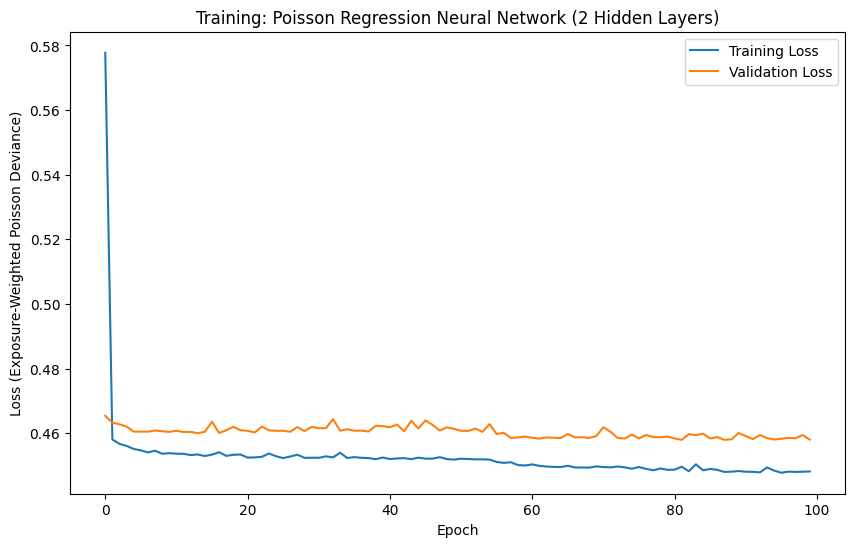

In [12]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Exposure-Weighted Poisson Deviance)')
plt.title(f'Training: Poisson Regression Neural Network (2 Hidden Layers)')
plt.legend()
plt.savefig('plots/training_history_FNN_1.png')

In [13]:
# Print MAE, MSE and loss on train and test data sets
def evaluate_model(nn_model, X, y, exposure):
    nn_model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X.values)
        y_pred = nn_model(X_tensor).numpy()
        return calculate_loss(y, y_pred, exposure)

print("\nTraining Set:")
fnn_1_res_train = evaluate_model(model, X_train, y_train, exposure_train)

print("\nTest Set:")
fnn_1_res_test = evaluate_model(model, X_test, y_test, exposure_test)


Training Set:
---------------------------------
MAE: 0.1915
MAE (Weighted): 0.1405
MSE: 3.7300
MSE (Weighted): 0.2335
Exposure-Weighted Poisson Deviance Loss: 0.4470
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4470
---------------------------------

Test Set:
---------------------------------
MAE: 0.2051
MAE (Weighted): 0.1418
MSE: 6.4987
MSE (Weighted): 0.2590
Exposure-Weighted Poisson Deviance Loss: 0.4580
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4580
---------------------------------


**COMMENT:** We can see, that we outperform the Poisson GLM model by a small margin only. We can also see, that after the first few epochs, the loss stays almost constant – the model converged. This suggests that there are too few parameters in the model to capture the complexity of the data (underfitting). So we try a different model with a hidden layer more and more neurons.

### Train new Poisson feedforward Neural Network with more parameters

Here, we train a new Poisson feedforward neural network with more parameters. We use 3 hidden layers with 256, 128 and 64 neurons. In order to avoid overfitting, we use regularization in the optimizer.

In [14]:
class PoissonNN_new(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3):
        super(PoissonNN_new, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.BatchNorm1d(hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.BatchNorm1d(hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.BatchNorm1d(hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, 1)
        )
    
    def forward(self, x):
        x = self.network(x).squeeze()   # Squeeze to remove extra dimension
        # Exponential activation function
        return torch.exp(x)

In [15]:
# Train Poisson Neural Network with regularization
model_new = PoissonNN_new(input_dim=input_dim, hidden_dim1=256, hidden_dim2=128, hidden_dim3=64)
print(model_new)

# NOTE: We use L2 regularization (weight decay) in the optimizer
# TODO: Implement Cross-Validation for L2 regularization
EPOCHS = 100
REGULARIZATION = 0.01
LEARNING_RATE = 0.001
optimizer = optim.Adam(model_new.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    # Training
    model_new.train()
    train_loss = 0
    total_exposure_train = 0.0
    for X_batch, y_batch, exp_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model_new(X_batch)
        loss = poisson_loss(y_pred, y_batch, exp_batch)
        loss.backward()
        optimizer.step()
        batch_size = X_batch.size(0)
        # Accumulate total loss and total exposure
        train_loss += loss.item() * exp_batch.sum().item()
        total_exposure_train += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    train_loss /= total_exposure_train

    # Validation
    model_new.eval()
    val_loss = 0
    total_exposure_val = 0.0
    with torch.no_grad():
        for X_batch, y_batch, exp_batch in test_loader:
            y_pred = model_new(X_batch)
            loss = poisson_loss(y_pred, y_batch, exp_batch)
            # Accumulate total loss and total exposure
            val_loss += loss.item() * exp_batch.sum().item()
            total_exposure_val += exp_batch.sum().item()

    # Compute the average exposure-weighted loss for the epoch
    val_loss /= total_exposure_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

PoissonNN_new(
  (network): Sequential(
    (0): Linear(in_features=42, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=1, bias=True)
  )
)
Epoch 0: Train Loss: 0.8615, Val Loss: 0.5615
Epoch 1: Train Loss: 0.4920, Val Loss: 0.4834
Epoch 2: Train Loss: 0.4642, Val Loss: 0.4776
Epoch 3: Train Loss: 0.4584, Val Loss: 0.4894
Epoch 4: Train Loss: 0.4595, Val Loss: 0.4661
Epoch 5: Train Loss: 0.4550, Val Loss: 0.4649
Epoch 6: Train Loss: 0.4561, Val Loss: 0.4633
Epoch 7: Train Loss: 0.4546, Val Loss: 0.4652
Epoch 8: Train Loss: 0.455


Training Set:
---------------------------------
MAE: 0.1937
MAE (Weighted): 0.1427
MSE: 3.7307
MSE (Weighted): 0.2338
Exposure-Weighted Poisson Deviance Loss: 0.4491
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4491
---------------------------------

Test Set:
---------------------------------
MAE: 0.2073
MAE (Weighted): 0.1439
MSE: 6.4996
MSE (Weighted): 0.2590
Exposure-Weighted Poisson Deviance Loss: 0.4568
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4568
---------------------------------


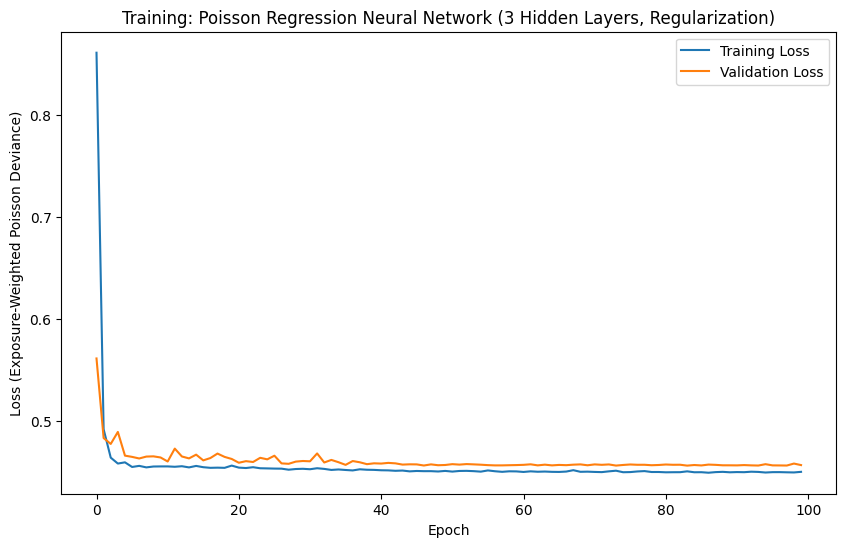

In [16]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (Exposure-Weighted Poisson Deviance)')
plt.title(f'Training: Poisson Regression Neural Network (3 Hidden Layers, Regularization)')
plt.legend()
plt.savefig('plots/training_history_FNN_2.png')

# Evaluate model
print("\nTraining Set:")
fnn_2_res_train = evaluate_model(model_new, X_train, y_train, exposure_train)

print("\nTest Set:")
fnn_2_res_test = evaluate_model(model_new, X_test, y_test, exposure_test)

***COMMENT:*** Again we see an increase in performance in regards of the test error. The training error stays roughly the same.

# Exercise 3 (Tree-based methods)

In [17]:
from sklearn import tree, ensemble, model_selection

# Ignore warning (we got lots of warning during GridSearchCV for too extreme hyperparameters)
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import make_scorer

from sklearn.metrics import check_scoring
from sklearn.utils.validation import check_array

class WeightedScorer:
    def __init__(self, scoring_function):
        """
        Initialize with a custom scoring function that accepts sample_weight.
        """
        self.scoring_function = scoring_function

    def __call__(self, estimator, X, y, sample_weight=None):
        """
        Compute the custom score with sample weights.
        """
        # Get predictions from the model
        y_pred = estimator.predict(X)

        # Ensure inputs are valid
        y = check_array(y, ensure_2d=False)
        y_pred = check_array(y_pred, ensure_2d=False)

        # Compute the score using the custom scoring function
        return self.scoring_function(y, y_pred, sample_weight=sample_weight)

# Define the custom scoring function
def weighted_neg_mean_poisson_deviance(y_true, y_pred, sample_weight=None):
    eps = 1e-8  # Avoid log(0)
    y_true_log = np.where(y_true > 0, y_true * np.log(y_true + eps), 0)
    y_pred_log = np.where(y_pred > 0, y_true * np.log(y_pred + eps), 0)
    deviance = 2 * (y_pred - y_true - y_pred_log + y_true_log)
    if sample_weight is not None:
        weighted_deviance = np.sum(sample_weight * deviance) / np.sum(sample_weight)
    else:
        print("Sample Weight: false")
        weighted_deviance = np.mean(deviance)
    return -weighted_deviance  # Negative for minimization

# Wrap the scoring function to make it compatible with sklearn
def custom_scorer(y_true, y_pred):
    # Include exposure_train implicitly (assumed available in the scope)
    return weighted_neg_mean_poisson_deviance(y_true,y_pred, sample_weight=exposure_train)

# Use make_scorer for compatibility
scorer = make_scorer(custom_scorer, greater_is_better=False)  # Minimization




### Question 3.a

In [18]:
from sklearn.model_selection import KFold


reg_tree = tree.DecisionTreeRegressor(criterion='poisson')

# Cross-validation on min_impurity_decrease hyperparameter
reg_tree_cv = model_selection.GridSearchCV(
    reg_tree, 
    param_grid={'min_impurity_decrease': np.linspace(0, 1e-4, 200)}, 
    cv=5, 
    scoring='neg_mean_poisson_deviance',
    verbose=1,
    n_jobs=-1
)
reg_tree_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("Best Hyperparameters: ", reg_tree_cv.best_params_)
print("Best Score: ", reg_tree_cv.best_score_)
best_reg_tree = reg_tree_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred = best_reg_tree.predict(X_train)
y_test_pred = best_reg_tree.predict(X_test)

print("\nTraining Set:")
reg_tree_res_train = calculate_loss(y_train, y_train_pred, exposure_train)

print("\nTest Set:")
reg_tree_res_test = calculate_loss(y_test, y_test_pred, exposure_test)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best Hyperparameters:  {'min_impurity_decrease': 6.783919597989949e-05}
Best Score:  -0.976255784557565

Training Set:
---------------------------------
MAE: 0.1872
MAE (Weighted): 0.1367
MSE: 3.7318
MSE (Weighted): 0.2340
Exposure-Weighted Poisson Deviance Loss: 0.4520
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4520
---------------------------------

Test Set:
---------------------------------
MAE: 0.2006
MAE (Weighted): 0.1377
MSE: 6.5004
MSE (Weighted): 0.2590
Exposure-Weighted Poisson Deviance Loss: 0.4585
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4585
---------------------------------


***Comment*** We first ran the grid search with param_grid={'min_impurity_decrease': np.logspace(-10, 0, 100)} to get a feeling what a good sclae of the parameter is. \
Best Hyperparameters:  {'min_impurity_decrease': 7.220809018385456e-05}, so we are in e-5 range. So now we look at this scale for a better parameter. \



### Question 3.b

In [19]:
# # Implement a random forest model
from sklearn.metrics import make_scorer, mean_poisson_deviance

# Define a custom scorer for Poisson deviance
def weighted_poisson_deviance(y_true, y_pred, sample_weight=None):
    return mean_poisson_deviance(y_true, y_pred, sample_weight=sample_weight)

custom_scorer = make_scorer(weighted_poisson_deviance, greater_is_better=False)

# Random Forest model
rf_reg = ensemble.RandomForestRegressor(criterion='poisson', n_jobs=4)  # Limit to 4 cores (somehow n_jobs=-1 works much slower)

# Cross-validation
rf_cv = model_selection.GridSearchCV(
    rf_reg,
    param_grid = {
        'random_state': [RANDOM_STATE],
        'n_jobs': [-1], # Parallelize training
        'min_impurity_decrease': [0.00001,0.0001,0.001,0.01,0.1],
        # number of features to consider when looking for best split, if None then max_features=n_features
        'max_features': [ 1,5, 10, 20,30 ,50]
    },
    cv=4,
    scoring=custom_scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the model
rf_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("\nRandom Forest Results:")
print("Best Hyperparameters: ", rf_cv.best_params_)
print("Best Score: ", rf_cv.best_score_)
best_rf = rf_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred_rf = best_rf.predict(X_train)
y_test_pred_rf = best_rf.predict(X_test)

print("\nTraining Set:")
rf_reg_res_train = calculate_loss(y_train, y_train_pred_rf, exposure_train)

print("\nTest Set:")
rf_reg_res_test = calculate_loss(y_test, y_test_pred_rf, exposure_test)


Fitting 4 folds for each of 30 candidates, totalling 120 fits

Random Forest Results:
Best Hyperparameters:  {'max_features': 10, 'min_impurity_decrease': 1e-05, 'n_jobs': -1, 'random_state': 69}
Best Score:  -0.971118079463454

Training Set:
---------------------------------
MAE: 0.1872
MAE (Weighted): 0.1370
MSE: 3.7199
MSE (Weighted): 0.2328
Exposure-Weighted Poisson Deviance Loss: 0.4420
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4420
---------------------------------

Test Set:
---------------------------------
MAE: 0.2012
MAE (Weighted): 0.1386
MSE: 6.5016
MSE (Weighted): 0.2592
Exposure-Weighted Poisson Deviance Loss: 0.4566
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4566
---------------------------------


### Question 3.c

In [20]:
# Implement gradient boosted trees
# NOTE: We use the Histogram-based Gradient Boosting Regressor as it is much faster than the "normal" Gradient Boosting Regressor
gb_reg = ensemble.HistGradientBoostingRegressor(loss='poisson')

# Cross-validation
gb_cv = model_selection.GridSearchCV(
    gb_reg,
     param_grid = {
        'random_state': [RANDOM_STATE],
        'learning_rate': np.linspace(0.02,0.3,101),  # shrinkage parameter
        'max_iter': [ 150,200,250,300]     # number of boosting steps
    },
    cv=5,
    scoring='neg_mean_poisson_deviance',
    verbose=1,
    n_jobs=-1
)
gb_cv.fit(X_train, y_train, sample_weight=exposure_train)

print("\nGradient Boosting Results:")
print("Best Hyperparameters: ", gb_cv.best_params_)
print("Best Score: ", gb_cv.best_score_)
best_gb = gb_cv.best_estimator_

# Print MAE, MSE and loss on train and test data sets
y_train_pred_gb = best_gb.predict(X_train)
y_test_pred_gb = best_gb.predict(X_test)

print("\nTraining Set:")
gb_reg_res_train = calculate_loss(y_train, y_train_pred_gb, exposure_train)

print("\nTest Set:")
gb_reg_res_test = calculate_loss(y_test, y_test_pred_gb, exposure_test)

Fitting 5 folds for each of 404 candidates, totalling 2020 fits

Gradient Boosting Results:
Best Hyperparameters:  {'learning_rate': 0.0312, 'max_iter': 150, 'random_state': 69}
Best Score:  -0.9710864072427061

Training Set:
---------------------------------
MAE: 0.1863
MAE (Weighted): 0.1355
MSE: 3.7297
MSE (Weighted): 0.2326
Exposure-Weighted Poisson Deviance Loss: 0.4408
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4408
---------------------------------

Test Set:
---------------------------------
MAE: 0.2000
MAE (Weighted): 0.1369
MSE: 6.5001
MSE (Weighted): 0.2582
Exposure-Weighted Poisson Deviance Loss: 0.4517
Exposure-Weighted Poisson Deviance Loss (sklearn): 0.4517
---------------------------------


## 4. Comparison of all the models & Conclusion

In this section, we compare all the considered models, that is:
- Poisson GLM
- Poisson FNN (42-20-20-1)
- Poisson FNN with more parameters (42-256-128-64-1) & regularization
- Regression Tree (CART)
- Random Forest
- Gradient Boosting

|          Model           |   Train MAE (weighted) |   Train MSE (weighted) |   Possion Train Loss |   Test MAE (weighted) |   Test MSE (weighted) |   Possion Test Loss |
|:------------------------:|-----------------------:|-----------------------:|---------------------:|----------------------:|----------------------:|--------------------:|
|       Poisson GLM        |                 0.1377 |                 0.2347 |               0.4563 |                0.1387 |                0.2597 |              0.4627 |
|   Poisson NN (Simple)    |                 0.1405 |                 0.2335 |               0.447  |                0.1418 |                0.259  |              0.458  |
| Poisson NN (Regularized) |                 0.1427 |                 0.2338 |               0.4491 |                0.1439 |                0.259  |              0.4568 |
|     Regression Tree      |                 0.1367 |                 0.234  |               0.452  |                0.1377 |               

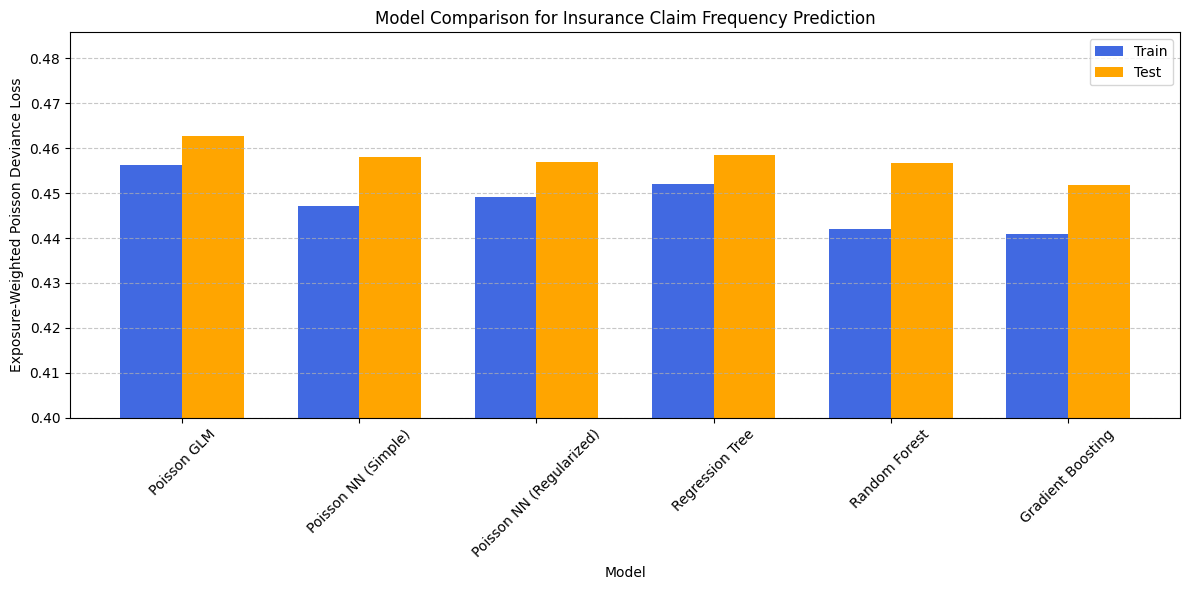

In [21]:
results = {
    'Poisson GLM': {
        'Train': poisson_glm_res_train,
        'Test': poisson_glm_res_test
    },
    'Poisson NN (Simple)': {
        'Train': fnn_1_res_train,
        'Test': fnn_1_res_test
    },
    'Poisson NN (Regularized)': {
        'Train': fnn_2_res_train,
        'Test': fnn_2_res_test
    },
    'Regression Tree': {
        'Train': reg_tree_res_train,
        'Test': reg_tree_res_test
    },
    'Random Forest': {
        'Train': rf_reg_res_train,
        'Test': rf_reg_res_test
    },
    'Gradient Boosting': {
        'Train': gb_reg_res_train,
        'Test': gb_reg_res_test
    }
}

# Plot results in a table
from tabulate import tabulate

table_data = []
headers = ['Model', 'Train MAE (weighted)', 'Train MSE (weighted)', 'Possion Train Loss', 'Test MAE (weighted)', 'Test MSE (weighted)', 'Possion Test Loss']

for model_name, model_results in results.items():
    train_mae, train_mae_weighted, train_mse, train_mse_weighted, train_poisson_loss = model_results['Train']
    test_mae, test_mae_weighted, test_mse, test_mse_weighted, test_poisson_loss = model_results['Test']
    
    table_data.append([
        model_name,
        f'{train_mae_weighted:.4f}',
        f'{train_mse_weighted:.4f}',
        f'{train_poisson_loss:.4f}',
        f'{test_mae_weighted:.4f}',
        f'{test_mse_weighted:.4f}',
        f'{test_poisson_loss:.4f}'
    ])

# Print table
print(tabulate(table_data, headers=headers, tablefmt='pipe', stralign='center'))

# Plot results as a bar chart
plt.figure(figsize=(12, 6))

train_poisson_loss = [results[model]['Train'][4] for model in results]
test_poisson_loss = [results[model]['Test'][4] for model in results]
bar_width = 0.35
index = np.arange(len(results))

plt.bar(index, train_poisson_loss, bar_width, label='Train', color='royalblue')
plt.bar(index + bar_width, test_poisson_loss, bar_width, label='Test', color='orange')

plt.xlabel('Model')
plt.ylabel('Exposure-Weighted Poisson Deviance Loss')
plt.title('Model Comparison for Insurance Claim Frequency Prediction')
plt.xticks(index + bar_width / 2, results.keys(), rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Set the y-axis limits to start at 0.40
plt.ylim(0.40, plt.ylim()[1])

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=1000)

**COMMENT:** Conclusion after implementing and benchmarking different models for insurance claim frequency prediction:
* Both Neural Network variants slightly outperformed the traditional Poisson GLM (test loss: 0.4576/0.4559 vs 0.4627)
* The (Histogram) Gradient Boosting Regressor showed the best performance with the lowest test loss (0.4517) and faster training time compared to the Neural Networks.

In conclusion, while Neural Networks improve upon the GLM baseline, the Gradient Boosting Regressor outperforms all of them (in terms of exposure-weighted Poisson deviance loss and computation time) and is therefore the best choice for this task.\
The next thing one could do to improve, is to better analyze the data. All models have the same scale of error. So we should preprocess the data such that it fits the assumptions better.
